In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import itertools
from gram_matrix_streamer import StreamGramMatrixMean, StreamGramMatrix
from rank1_topk_SVD_updater import Rank1UpdatableTopkSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


100%|██████████| 8192/8192 [00:09<00:00, 865.23it/s] 


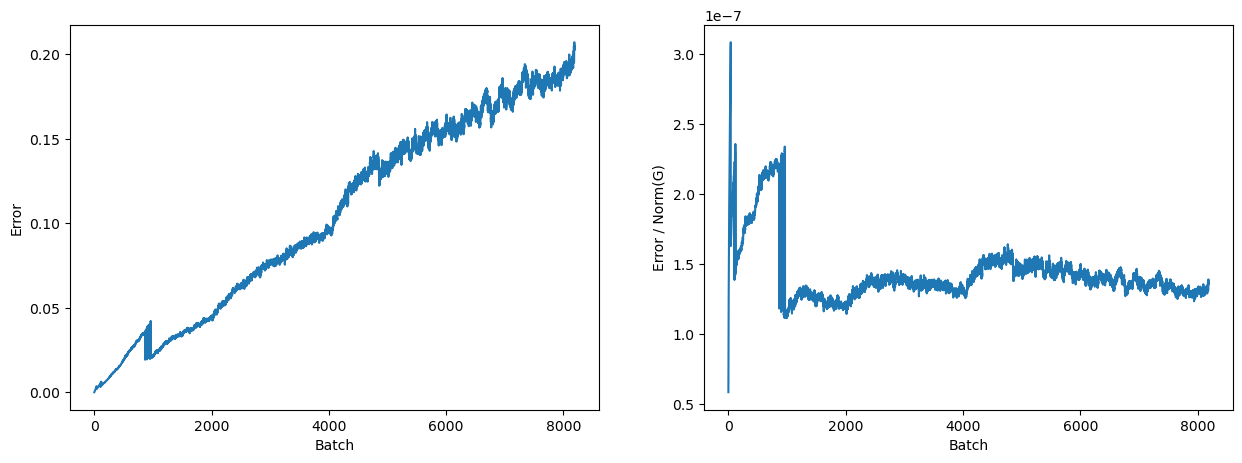

In [9]:
# distance of the streamed gram matrix from the true Gram matrix

num_samples = 2 ** 16
dim = 512
batch_size = 8
X = torch.randn(num_samples, dim, device=device)

gram_streamer = StreamGramMatrix(dim, X.device, X.dtype, internal_dtype=torch.float64)
error = []
G_norms = []

for i in tqdm(range(0, num_samples, batch_size)):
    gram_streamer.add(X[i:i+batch_size])
    G = X[:i+batch_size].T @ X[:i+batch_size]
    error.append(torch.norm(gram_streamer.get_gram_matrix() - G).item())
    G_norms.append(torch.norm(G).item())

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(error)
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Error")
axs[1].plot([e / g for e, g in zip(error, G_norms)])
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Error / Norm(G)")
plt.show()

512it [00:37, 13.65it/s]
512it [00:38, 13.26it/s]
512it [00:39, 12.89it/s]
512it [00:42, 12.05it/s]
512it [00:36, 14.13it/s]


Average update time Brand only: 2.52ms
Average update time Brand + full SVD every 32 updates: 4.70ms
Average update time Brand + 2 subspace iterations: 6.94ms
Average time when recomputing from scratch using randomized truncated SVD: 12.34ms
Average time when recomputing from scratch using torch.linalg.svd: 70.18ms


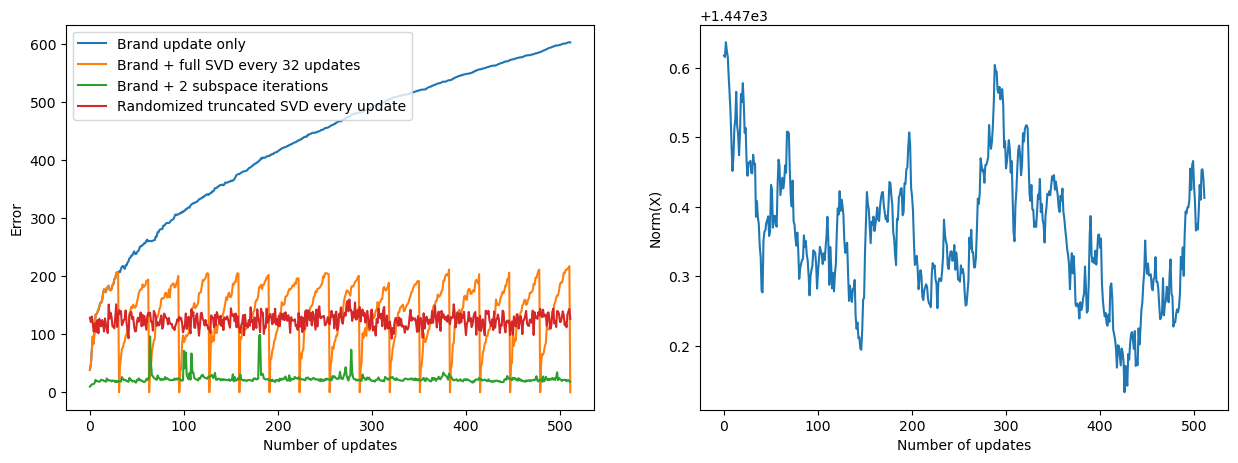

In [49]:
# accuracy of the SVD updater when randomly replacing rows and columns

updates = 512
m, n = 1024, 2048
rank = 64
oversample = 16
recomp_interval = 32
# subspace iteration parameters
subspace_iters = 2
use_expanded_subspace = True
# randomized truncated SVD parameters
rand_trunk_svd_iters = 20

# data generation
X = torch.randn(m, n, device=device)
row_updates = torch.randn(updates // 2, n, device=device)
row_indices = torch.randint(0, m, (updates // 2,)).tolist()
col_updates = torch.randn(updates // 2, m, device=device)
col_indices = torch.randint(0, n, (updates // 2,)).tolist()

svd_updater1 = Rank1UpdatableTopkSVD(X.clone(), k=rank, oversample=oversample, subspace_iters=0, recompute_every=0)
svd_updater2 = Rank1UpdatableTopkSVD(X.clone(), k=rank, oversample=oversample, subspace_iters=0, recompute_every=recomp_interval)
svd_updater3 = Rank1UpdatableTopkSVD(X.clone(), k=rank, oversample=oversample, subspace_iters=subspace_iters, use_expanded_subspace=use_expanded_subspace, recompute_every=0)
svd_updater4 = Rank1UpdatableTopkSVD(X.clone(), k=rank, oversample=oversample, recompute_every=1, use_rand_trunk_svd=True, rand_trunk_svd_iters=rand_trunk_svd_iters)
svd_updater5 = Rank1UpdatableTopkSVD(X.clone(), k=rank, oversample=oversample, recompute_every=1)

def test_updater(svd_updater, row_indices, col_indices, row_updates, col_updates, 
                 compute_errors=True, compute_X_norms=True):
    update_time = 0
    errors = []
    X_norms = []
    for i, (idx, x) in tqdm(enumerate(zip(itertools.chain(*zip(row_indices, col_indices)), itertools.chain(*zip(row_updates, col_updates))))):
        start_time = time.perf_counter()
        if not i % 2:
            svd_updater.replace_row(idx, x)
        else:
            svd_updater.replace_column(idx, x)
        update_time += time.perf_counter() - start_time
        if compute_errors:
            U, S, Vh = torch.linalg.svd(svd_updater.X, full_matrices=False)
            U = U[:, :rank]
            S = S[:rank]
            Vh = Vh[:rank, :]
            X_rec = U @ torch.diag(S) @ Vh
            errors.append(torch.norm(svd_updater.reconstruct() - X_rec).item())
        if compute_X_norms:
            X_norms.append(torch.norm(svd_updater.X).item())
    return update_time, errors, X_norms

update_time1, errors1, X_norms = test_updater(svd_updater1, row_indices, col_indices, row_updates, col_updates)
update_time2, errors2, _ = test_updater(svd_updater2, row_indices, col_indices, row_updates, col_updates, compute_X_norms=False)
update_time3, errors3, _ = test_updater(svd_updater3, row_indices, col_indices, row_updates, col_updates, compute_X_norms=False)
update_time4, errors4, _ = test_updater(svd_updater4, row_indices, col_indices, row_updates, col_updates, compute_X_norms=False)
update_time5, _, _ = test_updater(svd_updater5, row_indices, col_indices, row_updates, col_updates, compute_X_norms=False, compute_errors=False)

print(f"Average update time Brand only: {update_time1 / updates * 1000:.2f}ms")
print(f"Average update time Brand + full SVD every {recomp_interval} updates: {update_time2 / updates * 1000:.2f}ms")
print(f"Average update time Brand + {subspace_iters} subspace iterations: {update_time3 / updates * 1000:.2f}ms")
print(f"Average time when recomputing from scratch using randomized truncated SVD: {update_time4 / updates * 1000:.2f}ms")
print(f"Average time when recomputing from scratch using torch.linalg.svd: {update_time5 / updates * 1000:.2f}ms")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(errors1, label="Brand update only")
axs[0].plot(errors2, label=f"Brand + full SVD every {recomp_interval} updates")
axs[0].plot(errors3, label=f"Brand + {subspace_iters} subspace iterations")
axs[0].plot(errors4, label="Randomized truncated SVD every update")
axs[0].legend(loc="upper left")
axs[0].set_xlabel("Number of updates")
axs[0].set_ylabel("Error")
axs[1].plot(X_norms)
axs[1].set_xlabel("Number of updates")
axs[1].set_ylabel("Norm(X)")
plt.show()

In [ ]:
class LowRankUpdatableGramInverse:

    __slots__ = [
        'device','dtype','X','n','m','XXT_inv'
    ]

    def __init__(self, X: torch.Tensor) -> None:
        self.device, self.dtype = X.device, X.dtype
        self.X = X
        self.n: Final[int] = X.shape[0]
        self.m: Final[int] = X.shape[1]
        self.XXT_inv = torch.linalg.inv(X @ X.T)

    